
# Aufgabe 3 - Tiefe Einblicke ins Institut: Reloaded

Den Code immer nachvollziehbar kommentieren! Bitte beachtet, dass das Notebook von Anfang bis Ende ohne Fehler durchlaufen muss und dass die requirements.txt Datei aktualisiert wird.

In [62]:
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torch.optim as optim
from torchvision.io import read_image
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import numpy as np
import matplotlib.pyplot as plt

In [63]:
colab = False
directory = "Bilder"
# connect to google drive when using google colab for gpu
if colab:
    from google.colab import drive
    drive.mount('/content/drive')
    directory = "/content/drive/MyDrive/Colab Notebooks/Bilder"

## Teilaufgabe a): Trainings-, Test-und Validierungsdatenset

In [64]:
training_list = []
test_list = []
validation_list = []

# map the room/path names to an integer for integer classification
name_to_label = {
            'Professorenbuero': 0,
            'Flur': 1,
            'Labor': 2,
            'Teekueche': 3
        }
# load the images for each path, split and add them to the trainings, test and validation list
for path_name in name_to_label.keys():
    pic_amount = 25 #len(os.listdir(f"Bilder/{file_paths[name]}"))
    tmp_paths = [(f"{directory}/{path_name}/{path_name + str(i + 1)}.jpg", name_to_label[path_name])for i in range(pic_amount)] # (Tensor,lbl) list
    random.shuffle(tmp_paths)

    training_list += tmp_paths[:int(0.7 * pic_amount)]
    validation_list += tmp_paths[int(0.7 * pic_amount):int(0.8 * pic_amount)] # 3 pics each
    test_list += tmp_paths[int(0.8 * pic_amount):]

random.shuffle(training_list)
random.shuffle(test_list)
random.shuffle(validation_list)

# split the shuffled tupel lists into X and y: ["./pfad/zu/bildZ.png","./pfad/zu/bildY.png",...], [1,1,1,2,2,2,...]
training_path_list, y_train = [tup[0] for tup in training_list], [tup[1] for tup in training_list]
test_path_list, y_test = [tup[0] for tup in test_list], [tup[1] for tup in test_list]
validation_path_list, y_val = [tup[0] for tup in validation_list], [tup[1] for tup in validation_list]

## Teilaufgabe b): CNN definieren und implementieren

Wir haben uns dafür entschieden, ein CNN mit 3 Convolutional Layern und 2 Fully Connected Layern zu implementieren. Wir haben uns für die finale Architektur (Net) entschieden, da wir mit dieser Architektur empirisch die besten Ergebnisse erzielt haben. Es ist eine relativ leichte Architektur, die für einfache Bildklassifizierungen geeignet ist.

Die Vorteile der komplexeren Architekturen sind Dropoutlayer/Batchnormen, die Überanpassung vermeiden sollen. Wir haben uns gegen diese entschieden, da wir mit der finalen Architektur bereits gute Ergebnisse erzielt haben und die anderen Architekturen zu komplex für die Aufgabe sind.

In [65]:
class NetComplex(nn.Module):
    def __init__(self):
        super().__init__()
        # cite
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        #self.fc1 = nn.Linear(43264, 256)
        self.fc1 = nn.Linear(43264, 16)
        #self.fc2 = nn.Linear(256, 16)
        self.fc3 = nn.Linear(16, 4)

    def forward(self, x):
        #layer 1
        x = self.pool(F.relu(self.conv1(x)))
        x = self.bn1(x)
        #layer 2
        x = self.pool(F.relu(self.conv2(x)))
        x = self.bn2(x)
        # layer 3
        x = self.pool(F.relu(self.conv3(x)))
        x = self.bn3(x)
        # flatten
        x = torch.flatten(x, 1)
        # dense layers
        x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [66]:
class NetComplexP(nn.Module):
    def __init__(self):
        super().__init__()
        # cite
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(18432, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 4)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):

        #layer 1
        x = self.dropout(self.pool(F.relu(self.conv1(x))))
        #layer 2
        x = self.dropout(self.pool(F.relu(self.conv2(x))))
        # layer 3
        x = self.dropout(self.pool(F.relu(self.conv3(x))))
        # layer 4
        x = self.dropout(self.pool(F.relu(self.conv4(x))))
        # flatten
        x = torch.flatten(x, 1)
        # dense layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [67]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(3, 16, 4)
        self.pool = nn.MaxPool2d(2, 2)
        # Calculate the correct input size for the FC layer
        self.fc1 = nn.Linear(16 * 110 * 110, 1550)
        self.fc2 = nn.Linear(1550, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## Teilaufgabe e): Early Stopping

In [68]:
class EarlyStopper:

    def __init__(self, patience=1, min_delta=0, max_delta=float('inf')):
        """

        :param patience: how often the validation loss is accepted to be higher than the lowest validation loss before the training is stopped
        :param min_delta: offset added to the minimal loss as a lower bound for the violation counter
        :param max_delta: upper bound for the violation counter (optional to not stop training when the loss is way higher than it once was)
        """
        self.patience = patience
        self.min_delta = min_delta
        self.max_delta = max_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        """
        Method to check if the validation loss has not improved for several runs
        :param validation_loss: the validation loss of the last trainings run
        :return: true if training should be stopped
        """
        # if the given loss is lower that the minimal loss
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0 # reset the conunted violations
            print('\t --> new min validation loss [Early Stopper]')
        # else if the given loss i swithin the violation boundary
        elif (self.min_validation_loss + self.min_delta) < validation_loss < (self.min_validation_loss + self.max_delta):
            # increase the counter of the counted violations
            self.counter += 1
            print('\tEarly Stopper Counter: (', self.counter, ') [Early Stopper]')
            # if there have been more violations than the patience allows
            if self.counter >= self.patience:
                return True
        return False

## Teilaufgabe c) und d): Training und Test mit CNN und Augmentierung

Datenset-Klasse um mit Pytorch Bilder zu laden.

Input sind:
- Liste mit Pfaden zu Bildern
- Liste mit dazugehörigen Labels (numerisch darstellen!)
- Transformation der Bilder


In [69]:
class ROBDataset(Dataset):
    def __init__(self, img_path_list, img_labels, transform=None):
        # Pfade zu den Bildern als list
        self.img_path_list = img_path_list

        # Dazugehörige Labels zu den Bildern als list
        self.img_labels = img_labels

        # Transformations der Bilder
        self.transform = transform

    def __len__(self):
        return len(self.img_path_list)

    def __getitem__(self, idx):
        # Bild laden
        img_path = self.img_path_list[idx]
        image = read_image(img_path)

        # Label laden
        label = self.img_labels[idx]

        # Transformieren
        if self.transform:
            image = self.transform(image)

        return image.float(), int(label)

Trainingsiteration über alle Bilder.

Inputs sind:
- Pytorch dataloader Object über das iteriert wird
- bool do_backprob Parameter um Backpropagation durchzuführen oder nicht

In [70]:
from sklearn.metrics import accuracy_score


# Iterating over the entire data set once
def run_iteration(dataloader, do_backprob=True):
    global net, optimizer, criterion
    loss_iter = []
    acc_iter = []
    for batch_x, batch_y in dataloader:
        # To device
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        y_predict = net(batch_x)
        loss = criterion(y_predict, batch_y)
        if do_backprob:
            loss.backward()
            optimizer.step()

        # statistics
        loss_iter.append(loss.detach().cpu().numpy())

        _, predicted = torch.max(torch.softmax(y_predict, dim=1),1)

        acc_iter.append(accuracy_score(batch_y.detach().cpu().numpy(),
                                       predicted.detach().cpu().numpy()))

    return np.mean(loss_iter), np.mean(acc_iter)

Komplette Durchführung eines Trainings
Die Variablen y_train, y_val und y_test müssen noch gesetzt werden. Diese Listen beinhalten die entsprechenden Labels als numerische Darstellung.

Running on  cpu

Started Training
Epoch 1 from 100
	Train Loss	 54.350037
	Train Acc.	 0.3875
	Val Loss	 63.96292
	Val Acc.	 0.25
	 --> new min validation loss [Early Stopper]
Epoch 2 from 100
	Train Loss	 30.885952
	Train Acc.	 0.3125
	Val Loss	 13.898656
	Val Acc.	 0.5
	 --> new min validation loss [Early Stopper]
Epoch 3 from 100
	Train Loss	 13.95708
	Train Acc.	 0.475
	Val Loss	 9.745544
	Val Acc.	 0.5833333333333334
	 --> new min validation loss [Early Stopper]
Epoch 4 from 100
	Train Loss	 5.2195625
	Train Acc.	 0.5375
	Val Loss	 7.122868
	Val Acc.	 0.3333333333333333
	 --> new min validation loss [Early Stopper]
Epoch 5 from 100
	Train Loss	 4.177617
	Train Acc.	 0.3875
	Val Loss	 2.9132042
	Val Acc.	 0.5
	 --> new min validation loss [Early Stopper]
Epoch 6 from 100
	Train Loss	 2.5362782
	Train Acc.	 0.6
	Val Loss	 3.1330688
	Val Acc.	 0.5
	Early Stopper Counter: ( 1 ) [Early Stopper]
Epoch 7 from 100
	Train Loss	 2.2725098
	Train Acc.	 0.5375
	Val Loss	 1.2034726
	Val Acc.	 

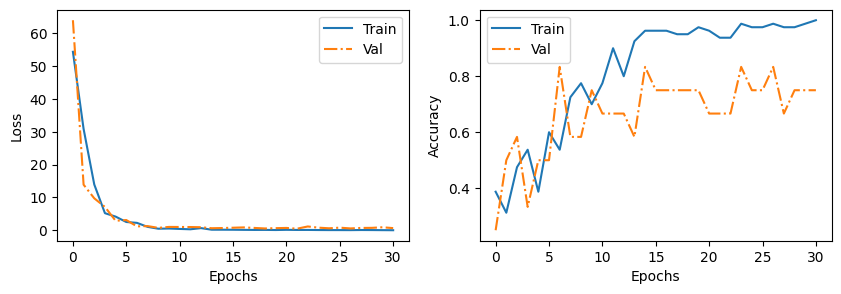

In [71]:
# Training settings - bei Bedarf anpassbar
max_epoch = 100
batch_size = 16
lr = 0.001

# Transformations for dataloader including augumentation
t_train = T.Compose([T.ToPILImage(),
                   T.Resize((224,224)),
                   T.ColorJitter(hue=.05, saturation=.05),
                   T.RandomHorizontalFlip(),
                   T.RandomRotation(20),
                   T.ToTensor(),
                   T.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))])
t_val = T.Compose([T.ToPILImage(),
                   T.Resize((224,224)),
                   T.ColorJitter(hue=.05, saturation=.05),
                   T.RandomHorizontalFlip(),
                   T.RandomRotation(20),
                   T.ToTensor(),
                   T.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))])
t_test = T.Compose([T.ToPILImage(),
                   T.Resize((224,224)),
                   T.ColorJitter(hue=.05, saturation=.05),
                   T.RandomHorizontalFlip(),
                   T.RandomRotation(20),
                   T.ToTensor(),
                   T.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))])
# Where to do calculations
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running on ",device)

# Training Data, NOTE: y_train labels need to be set
dataset_train = ROBDataset(training_path_list, y_train, transform=t_train)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

# Validation Data, NOTE: y_val labels need to be set
dataset_val = ROBDataset(validation_path_list, y_val, transform=t_val)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)

# Test Data, NOTE: y_test labels need. to be set
dataset_test = ROBDataset(test_path_list, y_test,transform=t_test)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

# Network, optimizer and loss initialisation
net = Net()
net.to(device)
optimizer = optim.Adam(net.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# Los geht's mit Training
print("\nStarted Training")
# Training loss and accuracy per epoch
train_loss_epoch = []
train_acc_epoch = []
# Validation loss and accuracy per epoch
val_loss_epoch = []
val_acc_epoch = []
# Early Stopper
early_stopper = EarlyStopper(patience=5, min_delta=0.05, max_delta=0.5)

for epoch in range(0,max_epoch):  # loop over the dataset multiple times
    print(f"Epoch {epoch+1} from {max_epoch}")

    ### TRAINING ###
    net.train()
    train_loss_iter, train_acc_iter = run_iteration(dataloader_train)

    # Logging loss and accuarcy of training iteration
    train_loss_epoch.append(train_loss_iter)
    train_acc_epoch.append(train_acc_iter)
    print("\tTrain Loss\t",train_loss_iter)
    print("\tTrain Acc.\t",train_acc_iter)

    ### VALIDATION ###
    with torch.no_grad():  # No gradient calculation
        net.eval()
        val_loss_iter, val_acc_iter = run_iteration(dataloader_val,do_backprob=False)

        # Logging loss and accuarcy of validation iteration
        val_loss_epoch.append(val_loss_iter)
        val_acc_epoch.append(val_acc_iter)
        print("\tVal Loss\t",val_loss_iter)
        print("\tVal Acc.\t",val_acc_iter)

    if early_stopper.early_stop(val_loss_iter):
        break

# Plotting results
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10,3))
ax[0].plot(train_loss_epoch,label="Train")
ax[0].plot(val_loss_epoch,label="Val",linestyle="-.")
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].legend()

ax[1].plot(train_acc_epoch,label="Train")
ax[1].plot(val_acc_epoch,label="Val",linestyle="-.")
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].legend()
plt.savefig("loss_augmentation.png",format="png",bbox_inches="tight")

Berechnung der Accuracy und der Scores auf den Trainingsdaten

In [73]:
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix
y_pred = [] # Create an empty list to store the predicted values
correct = 0
total = 0

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in dataloader_test:
        images, labels = data
        if torch.cuda.is_available():
            images, labels = images.cuda(), labels.cuda() # send to gpu
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy())  # Append the predicted values to the list
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy: {100 * correct // total} %')
print("F1 Score:", f1_score(y_test, y_pred, average='micro'))
print("Recall:", recall_score(y_test, y_pred, average='micro'))
print("Precision:", precision_score(y_test, y_pred, average='micro'))
print('Confusion matrix:\n', confusion_matrix(y_test, y_pred))

Accuracy: 70 %
F1 Score: 0.7
Recall: 0.7
Precision: 0.7
Confusion matrix:
 [[4 0 1 0]
 [0 5 0 0]
 [0 0 3 2]
 [1 0 2 2]]
